# Исследование продаж компьютерных игры интернет-магазина «Стримчик»

**Цель работы**

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.
Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными.

**План работы**

1.[Изучение данных](#1)

2.[Подготовка данных](#2)

3.[Исследовательский анализ данных](#3)

4.[Портрет пользователя каждого региона](#4)

5.[Проверка гипотез](#5)

6.[Итоговые выводы](#6)

**Описание данных**

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

<a id='1'></a>
## Изучение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

df = pd.read_csv('/datasets/games.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [2]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Пропуски в `name` и `genre` вероятно пропущены случайно. При изучении пропусков в `year_of_release` закономерности в пропусках тоже не выявлены. Пропуски в `critic_score`, `user_score` и `rating` в большинстве случаев появляются одновременно. Вероятно игра не учавствовала в процессе оценки и получения рейтинга ESRB.

<a id='2'></a>
## Подготовка данных

### Приведение к нижнему регистру названия столбцов

In [3]:
df.columns = df.columns.str.lower()
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


### Преобразование типов

In [4]:
# преобразование в int для year_of_release
df.year_of_release = df.year_of_release.astype('Int64')

В `user_score` присутствуют значения 'tbd'. Это означает, что значение будет определено в дальнейшем. Для преобразования в число, заменим это значение на Nan.

In [5]:
df.loc[df.user_score == 'tbd','user_score'] = np.nan
df.user_score = df.user_score.astype(np.float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null Int64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


### Обработка пропусков

Пустые значения в `name` и `genre` это всего лишь две записи. Это не повлияет на дальнейший анализ, поэтому не заполняем.

In [6]:
df[df['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Доля пустых значений в `year_of_release` не превышает 2%. Заполнить часть из этих данных можно было бы основываясь на названии игры, но при дальнейшем исследовании некоторых игры, выяснилось: Год в названии игры, не всегда соответствует релизному году. Поэтому пропуски в этом столбце заполняться не будут. 

In [7]:
df[df['year_of_release'].isnull()].index.shape[0] / df.shape[0]

0.01609332934489979

Также имеются пропуски в столбцах с оценками. Взаимосвязь оценок и продаж (данные по продажам имеются в полном объеме) достаточно сложная. Ее мы в дальнейшем будем исследовать в том числе. Поэтому заполнение пустых оценок на основе остальных признаков производить не будем. 

Заполнение пропусков в столбце с рейтингом (ESRB) тоже не подразумевается. Можно было бы предположить зависимость жанра и рейтинга, но исследовав данные, выяснили что в одном жанре может быть достаточно большой разброс по рейтингам.

In [8]:
df.pivot_table(index=['genre','rating'], values='name', aggfunc=['count'])

count
                     name
genre        rating      
Action       AO         1
             E        416
             E10+     481
             EC         1
             M        608
             T        681
Adventure    E        162
             E10+      68
             EC         2
             M         99
             T        115
Fighting     E          8
             E10+      19
             M         49
             T        362
Misc         E        457
             E10+     167
             EC         5
             K-A        1
             M         13
             T        239
Platform     E        358
             E10+     144
             M          3
             T         64
Puzzle       E        289
             E10+      43
             T         10
Racing       E        585
             E10+      96
             M         18
             RP         1
             T        172
Role-Playing E         84
             E10+     111
             M        162
             T        420
Shooter      E         48
             E10+      58
             M        565
             T        348
Simulation   E        325
             E10+      48
             M          5
             T        190
Sports       E       1188
             E10+     107
             M         16
             T        198
Strategy     E         70
             E10+      78
             K-A        2
             M         25
             RP         2
             T        162

### Рассчет суммарных продаж по всем регионам

In [9]:
df['sales'] = df.na_sales + df.eu_sales + df.jp_sales + df.other_sales
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


<a id='3'></a>
## Исследовательский анализ данных

### Определение актуального периода по которому можно будет построить прогноз на 2017

Узнаем как менялось кол-во выпущенных игр по годам.

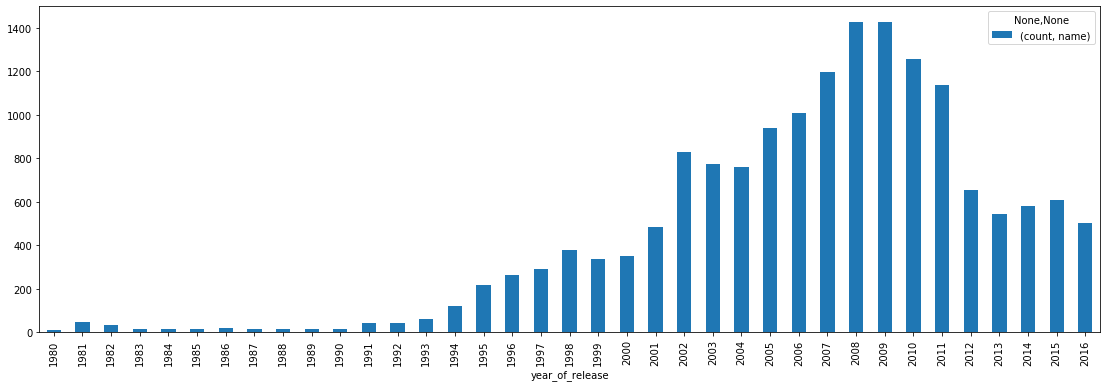

In [10]:
df.pivot_table(index='year_of_release', values='name', aggfunc=['count']).plot(kind='bar', figsize=(19, 6))

По графику видно, что игры стали активнее выпускаться начиная с 1991 года. 


Возможные причины спада в индустрии последних лет с логической точки зрения:
- потеря качества контента в связи с перенасыщением рынка (делают акцент на количество, а не на качество)
- рост цен на игры (запуск платформ у которых достаточно сложно взломать лицензии, в итоге нежелание людей покупать новые дорогостоящие игры)
- потеря интереса (старые игры уже надоели, а новых достойных игр не выходит)


Далее рассмотрим топ-платформ по продажам.

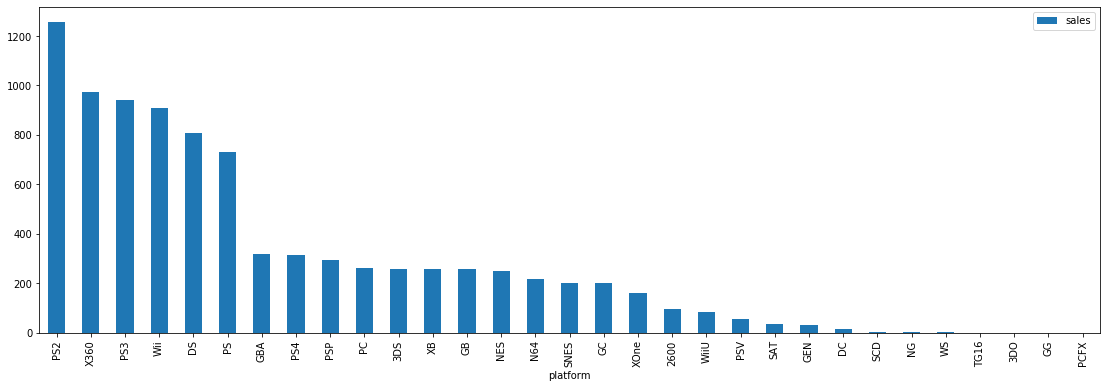

In [11]:
df.pivot_table(index='platform', values='sales', aggfunc='sum').sort_values(by = 'sales', ascending=False)\
.plot(kind='bar', figsize=(19, 6))

Исходя их графика выберем платформы с порогом продаж более 150 млн. копий. Также исключим из анализа платформы, которые только начинают свой путь (их мы определили по этим [графикам](#gr))

In [12]:
# выделим в отдельный лист топ и сформируем по нему новый датасет
pl = df.pivot_table(index='platform', values='sales', aggfunc='sum').sort_values(by = 'sales', ascending=False)
pl_list = pl.query('sales > 150').index.to_list()
pl_new_list = ['PS4','3DS','PSV','WiiU','XOne']
df_sal_top = df.query('platform in @pl_list and platform not in @pl_new_list')

Посчитаем средний характерный "срок жизни" игровой платформы в годах

AxesSubplot(0.125,0.125;0.775x0.755)


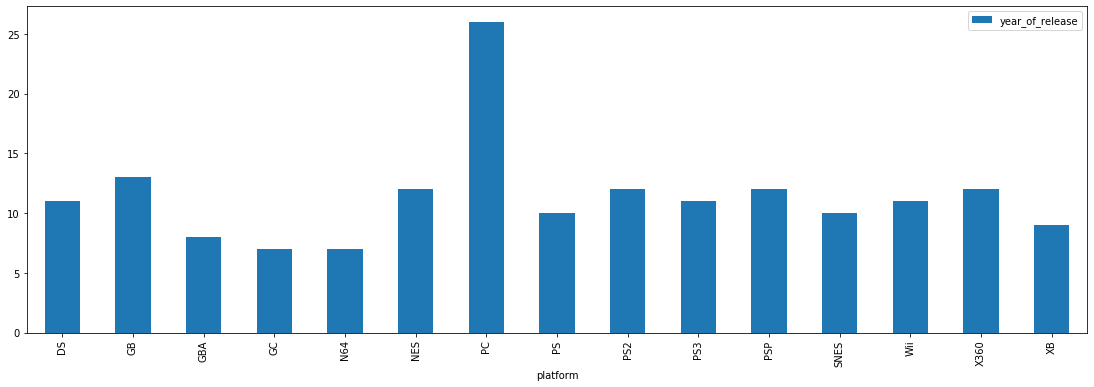

In [13]:
print (df_sal_top.pivot_table(index=['platform', 'year_of_release'], values='sales', aggfunc='sum').reset_index(level=1)\
       .pivot_table(index='platform', values='year_of_release', aggfunc='count').plot(kind='bar', figsize=(19, 6)))

In [14]:
print ('Среднее', df_sal_top.pivot_table(index=['platform', 'year_of_release'], values='sales', aggfunc='sum')\
       .reset_index(level=1).pivot_table(index='platform', values='year_of_release', aggfunc='count').mean())

Среднее year_of_release    11.4
dtype: float64


Будем считать **актуальный период** для прогноза на 2017: 2012-2016. Далее в работе будем использовать срез по актуальному периоду.

In [15]:
data = df.query('year_of_release > 2011')
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


### Определение потенциальных лидеров продаж среди платформ

Построим график продаж за весь период в разбивке по платформам

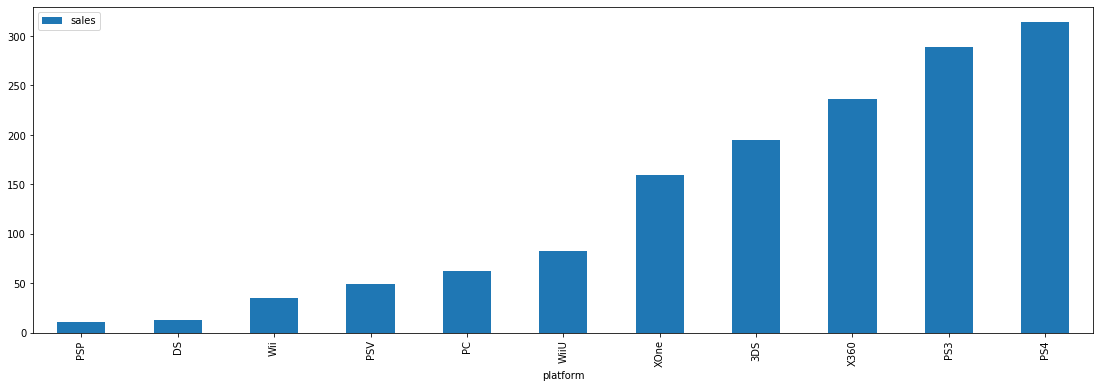

In [16]:
data.pivot_table(index='platform', values='sales', aggfunc='sum').sort_values(by = 'sales')\
.plot(kind='bar', figsize=(19, 6))

<a id='gr'></a>
Построим график продаж по платформам и годам

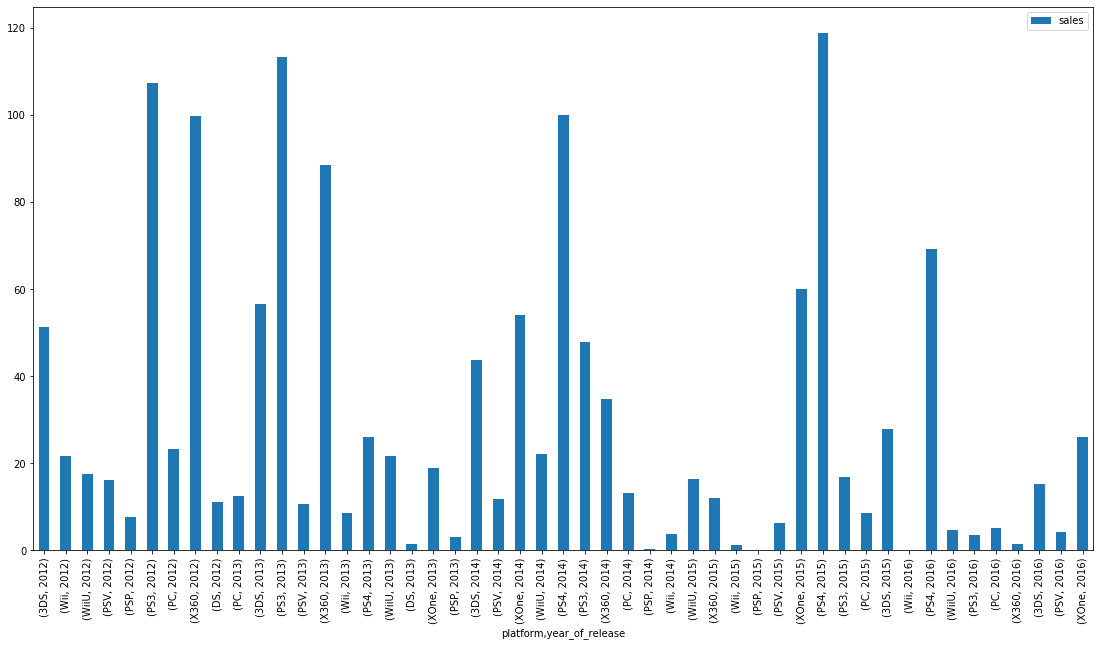

In [17]:
data.pivot_table(index=['platform','year_of_release'], values='sales', aggfunc='sum')\
.sort_values(by = 'year_of_release').plot(kind = 'bar',subplots=False, figsize=(19, 10))

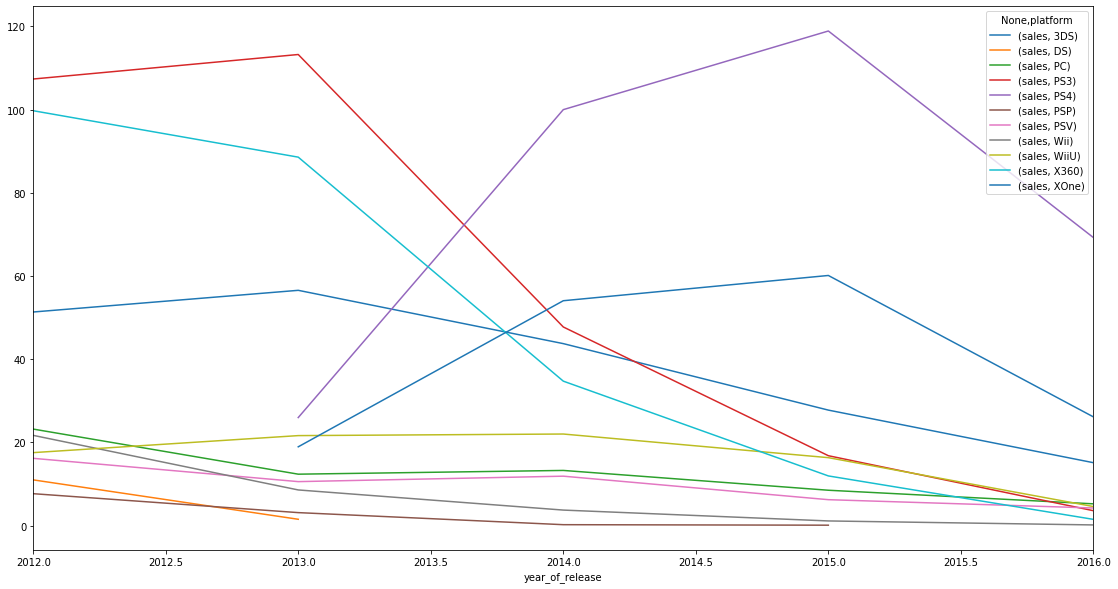

In [18]:
data.pivot_table(index=['platform','year_of_release'], values='sales', aggfunc='sum')\
.sort_values(by = 'year_of_release').unstack(level=0).plot(subplots=False, figsize=(19, 10))

Изучив графики, выделим потенциально прибыльные платформы:
- PS4
- XOne
- 3DS
- PC
- WiiU

Этот список формировался по общим продажам и уровню продаж за последние несколько лет. В большей степени учитывались показатели за последние года, тк по последнему графику видно, что некогда популярные платформы теряют свой статус и уступают новичкам. В целом можно сказать, что продажи падают, за исключением новых платформ появившихся ближе к концу периода. Но даже их рост не был длительным - тк видно падение к 2016 по всем платформам.

### Изучим боксплоты продаж игр в разбивке по платформам

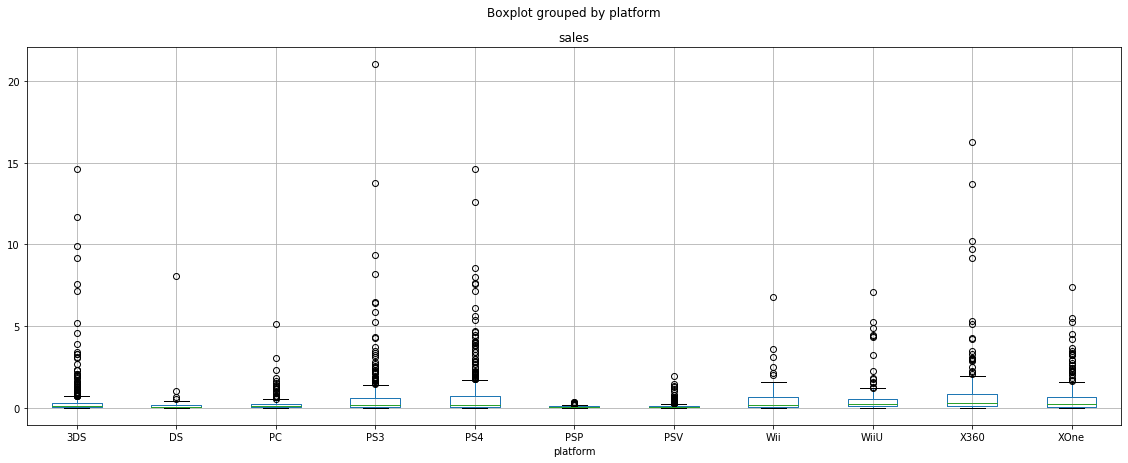

In [19]:
np.warnings.filterwarnings("ignore")
data.boxplot(column='sales', by ='platform', figsize=(19, 7))

В целом продажи игр у популярных платформ за весь период в границах первой и третьей квантили - одинаковы. Также наблюдаются больше выбросов у популярных платформ, нежели чем у менее популярных (что достаточно логично).
Разница между платформами по выбросам может быть обусловлена "успешностью и популярностью" отдельных игр. 

### Изучение влияния на продажи отзывов пользователей и критиков

Для изучения возьмем топ-платформу по продажам за период - PS4

In [20]:
print('Продажи PS4 - отзывы критиков:',data.query('platform == "PS4"')['sales']\
      .corr(data.query('platform == "PS4"')['critic_score']))
print('Продажи PS4 - отзывы пользователей:',data.query('platform == "PS4"')['sales']\
      .corr(data.query('platform == "PS4"')['user_score']))

Продажи PS4 - отзывы критиков: 0.406567902061781
Продажи PS4 - отзывы пользователей: -0.031957110204556424


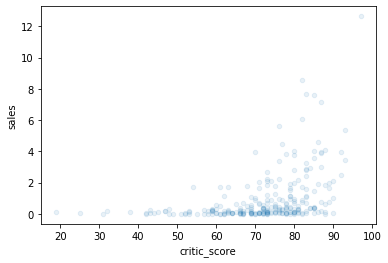

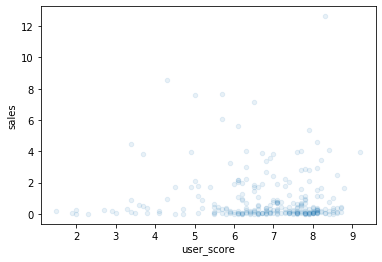

In [21]:
data.query('platform == "PS4"').plot(x='critic_score', y='sales', kind='scatter', alpha=0.1)
plt.show()

data.query('platform == "PS4"').plot(x='user_score', y='sales', kind='scatter', alpha=0.1)
plt.show()

Изучив значения корреляций и диаграммы можно сделать следующие выводы:

- связь между продажами и отзывами критиков есть, но она не сильно выражена (наблюдается положительная корреляция - чем выше оценки, тем больше продаж)
- связи между продажами и отзывами пользователей нет

Далее исследуем корреляции по другим платформам

In [22]:
for plat in data.platform.value_counts().index.to_list():
    print('--',plat,'--')
    print('Продажи - отзывы критиков:',data.query('platform == @plat')['sales']\
      .corr(data.query('platform == @plat')['critic_score']))
    print('Продажи - отзывы пользователей:',data.query('platform == @plat')['sales']\
      .corr(data.query('platform == @plat')['user_score']))

-- PS3 --
Продажи - отзывы критиков: 0.3314972592629587
Продажи - отзывы пользователей: -0.005143522887113816
-- PSV --
Продажи - отзывы критиков: 0.09448789929316172
Продажи - отзывы пользователей: -0.004339437514314869
-- 3DS --
Продажи - отзывы критиков: 0.32080286953607845
Продажи - отзывы пользователей: 0.19758263411038596
-- PS4 --
Продажи - отзывы критиков: 0.406567902061781
Продажи - отзывы пользователей: -0.031957110204556424
-- X360 --
Продажи - отзывы критиков: 0.36057348885073365
Продажи - отзывы пользователей: 0.0061639786462133256
-- PC --
Продажи - отзывы критиков: 0.23724324311567918
Продажи - отзывы пользователей: -0.12186747630735577
-- XOne --
Продажи - отзывы критиков: 0.41699832800840175
Продажи - отзывы пользователей: -0.06892505328279412
-- PSP --
Продажи - отзывы критиков: nan
Продажи - отзывы пользователей: -0.802302061939321
-- WiiU --
Продажи - отзывы критиков: 0.3483797601201749
Продажи - отзывы пользователей: 0.4002190202148617
-- Wii --
Продажи - отзывы кр

Не для всех платформ наблюдается подобная корреляци, как в лидирующей PS4. В целом общая тенденция следующая: отзывы критиков в большей степени положительно коррелируют с продажами, нежели чем оценки пользователей. Но есть исключение - платформа WiiU. В ней отзывы пользователей коррелируют в большей степени.

### Изучение распределения игр по жанрам

Построим график итоговых продаж по жанрам

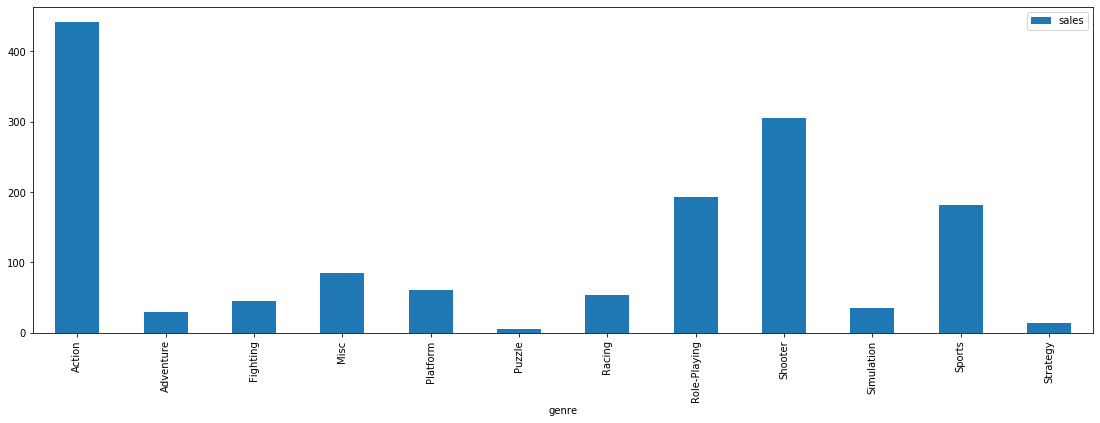

In [23]:
data.pivot_table(index='genre', values='sales', aggfunc='sum').plot(kind='bar', figsize=(19, 6))

Среди лидеров можно выделить: Action, Shooter и Role-Playing. Аутсайдеры: Puzzle и Strategy

Далее исследуем лидеров

In [24]:
print ('Action')
print (data.query('genre == "Action"')['sales'].describe())
print ('Shooter')
print (data.query('genre == "Shooter"')['sales'].describe())
print('Sports')
print (data.query('genre == "Role-Playing"')['sales'].describe())

Action
count    1031.000000
mean        0.427856
std         1.166504
min         0.010000
25%         0.030000
50%         0.120000
75%         0.390000
max        21.050000
Name: sales, dtype: float64
Shooter
count    235.000000
mean       1.296723
std        2.251662
min        0.010000
25%        0.135000
50%        0.440000
75%        1.480000
max       14.630000
Name: sales, dtype: float64
Sports
count    370.000000
mean       0.521081
std        1.315937
min        0.010000
25%        0.060000
50%        0.140000
75%        0.407500
max       14.600000
Name: sales, dtype: float64


Action               AxesSubplot(0.1,0.559091;0.363636x0.340909)
Role-Playing    AxesSubplot(0.536364,0.559091;0.363636x0.340909)
Shooter                  AxesSubplot(0.1,0.15;0.363636x0.340909)
dtype: object

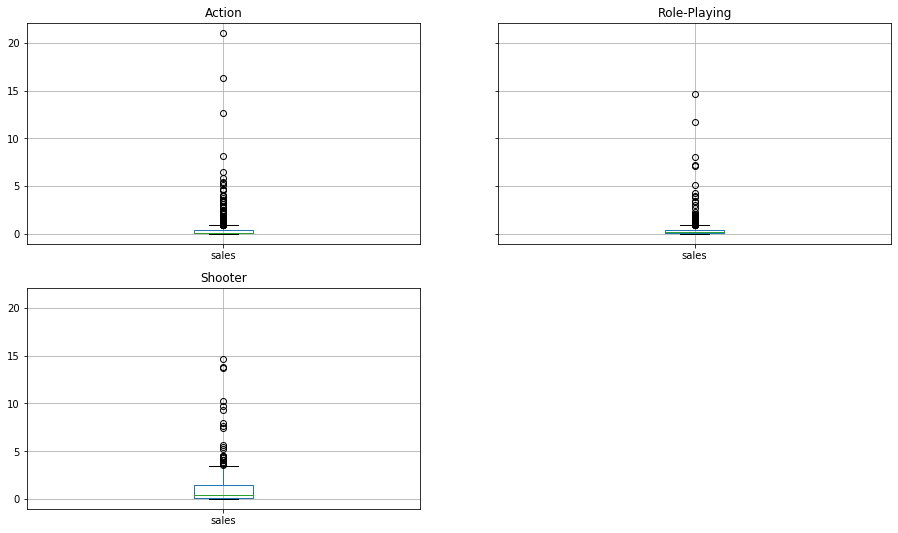

In [25]:
data.query('genre == "Action" or genre == "Shooter" or genre == "Role-Playing"').groupby('genre')\
.boxplot(column='sales', figsize=(15, 9))

Можно отметить, что хоть и Action является явным лидером по продажам, у Shooter каждая игра в среднем продается большим кол-вом копий. Также для Shooter характерен больший разброс от среднего в продажах по играм.

<a id='4'></a>
## Портрет пользователя каждого региона

### Топ-5 платформ по продажам в регионах

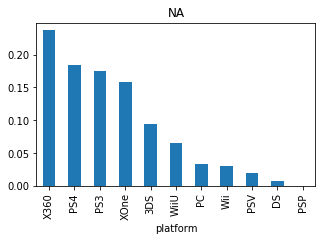

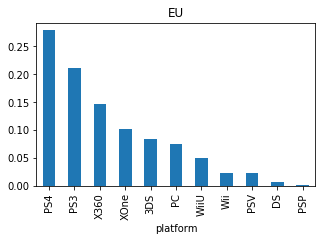

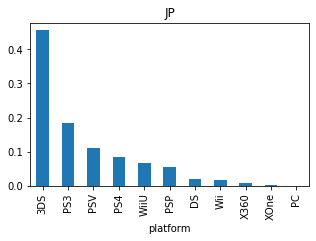

In [26]:
sv = data.pivot_table(index='platform', values=['na_sales','eu_sales','jp_sales'], aggfunc='sum')
sv['na_sales'] = sv.na_sales / sv.na_sales.sum()
sv['eu_sales'] = sv.eu_sales / sv.eu_sales.sum()
sv['jp_sales'] = sv.jp_sales / sv.jp_sales.sum()

sv['na_sales'].sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='NA')
plt.show()
sv['eu_sales'].sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='EU')
plt.show()
sv['jp_sales'].sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='JP')
plt.show()

Изучив доли продаж, выявили следующие топ-5 платформ по регионам: 

**Северная Америка**: X360, PS4, PS3, XOne, 3DS.

**Европа**: PS4, PS3, X360, XOne, 3DS.

**Япония**: 3DS, PS3, PSV, PS4, WiiU.

Можно сказать, что вкусы пользователей касательно выбора платформ не отличаются в Северной Америке и Европе. А вот Япония выделяется на фоне остальных. В Японии в топе оказалось три портативные платформы (3DS, PSV, WiiU), в Европе и Северной Америке только одна и то на позициях аутсайдера в топ-5. В следствии для Японии можно выделить "моду" на компактные и легко-переносимые игровые платформы.

### Топ-5 жанров по продажам в регионах

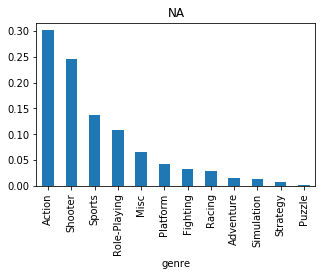

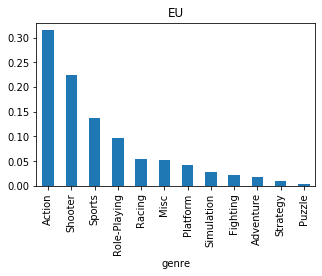

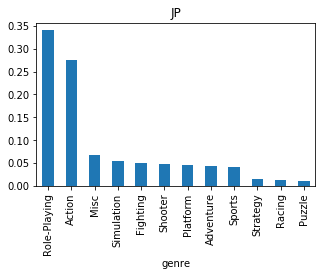

In [27]:
sv2 = data.pivot_table(index='genre', values=['na_sales','eu_sales','jp_sales'], aggfunc='sum')
sv2['na_sales'] = sv2.na_sales / sv2.na_sales.sum()
sv2['eu_sales'] = sv2.eu_sales / sv2.eu_sales.sum()
sv2['jp_sales'] = sv2.jp_sales / sv2.jp_sales.sum()

sv2['na_sales'].sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='NA')
plt.show()
sv2['eu_sales'].sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='EU')
plt.show()
sv2['jp_sales'].sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='JP')
plt.show()

Изучив доли продаж, выявили следующие топ-5 жанров по регионам: 

**Северная Америка**: Action, Shooter, Sports, Role-Playing, Misc.

**Европа**: Action, Shooter, Sports, Role-Playing, Racing.

**Япония**: Role-Playing, Action, Misc, Simulation, Fighting.

И в предпочтении жанров можно обнаружить вкусовые различия между Японией и Северная Америка/Европа. Особенно выделяется жанр Role-Playing в Японии. Он покрывает около 35 процентов от всех продаж по региону.  

### Влияние рейтинга ESRB на продажи в отдельном регионе

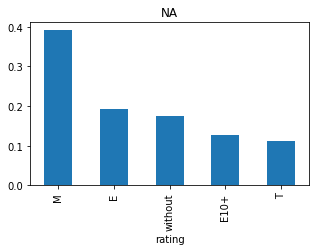

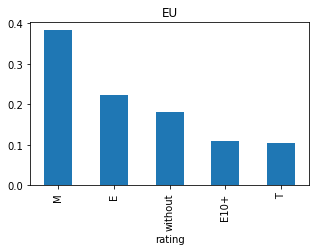

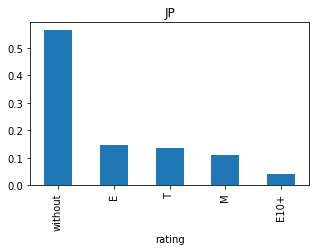

In [28]:
#заполним пропуски в рейтинге
data['rating'].fillna('without',inplace=True)

sv3 = data.pivot_table(index='rating', values=['na_sales','eu_sales','jp_sales'], aggfunc='sum')
sv3['na_sales'] = sv3.na_sales / sv3.na_sales.sum()
sv3['eu_sales'] = sv3.eu_sales / sv3.eu_sales.sum()
sv3['jp_sales'] = sv3.jp_sales / sv3.jp_sales.sum()

sv3['na_sales'].sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='NA')
plt.show()
sv3['eu_sales'].sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='EU')
plt.show()
sv3['jp_sales'].sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='JP')
plt.show()

Снова обнаружили отличия в Японии. Рейтинги "E"(6+) "Т"(12+) имееет большую долю продаж, по сравнению с "М"(+17). Вероятно сказывается более жесткая политка цензуры для Японии по сравнению с Америкой и Европой. Также больше 50 процентов игр, проданных в Японии, без указания рейтинга.

<a id='5'></a>
## Проверка гипотез

Первое исследование.

Сформулируем нулевую гипотезу H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Тогда альтернативная гипотеза H1: Средние пользовательские рейтинги платформ Xbox One и PC различаются.

Тип гипотезы - Гипотеза о равенстве средних двух генеральных совокупностей. Используем критерий Стьюдента.

In [29]:
print ('Средние пользовательские рейтинги XboxOne',data.loc[data['platform'] == 'XOne','user_score'].mean())
print ('Средние пользовательские рейтинги PC',data.loc[data['platform'] == 'PC','user_score'].mean())

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(data.loc[data['platform'] == 'XOne','user_score'].dropna().to_list(),\
                       data.loc[data['platform'] == 'PC','user_score'].dropna().to_list())

print('')
print ('H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Средние пользовательские рейтинги XboxOne 6.521428571428572
Средние пользовательские рейтинги PC 6.428640776699029

H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что с вероятностью в 5,5% текущее или большее различие между средними выборок можно получить случайно. Это не слишком большая вероятность, чтобы делать вывод об отсутствии значимого различия между средними пользовательскими рейтингами платформ Xbox One и PC. Если брать стат.значимость (alpha = 0.1), то мы бы отвергли нулевую гипотезу.

Второе исследование.

Сформулируем нулевую гипотезу H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые. Тогда альтернативная гипотеза H1: Средние пользовательские рейтинги жанров Action и Sports разные.

Тип гипотезы - Гипотеза о равенстве средних двух генеральных совокупностей. Используем критерий Стьюдента.

In [30]:
print ('Средние пользовательские рейтинги Action',data.loc[data['genre'] == 'Action','user_score'].mean())
print ('Средние пользовательские рейтинги Sports',data.loc[data['genre'] == 'Sports','user_score'].mean())

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results2 = st.ttest_ind(data.loc[data['genre'] == 'Action','user_score'].dropna().to_list(),\
                       data.loc[data['genre'] == 'Sports','user_score'].dropna().to_list())

print('')
print ('H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые')
print('p-значение:', results2.pvalue)

if results2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Средние пользовательские рейтинги Action 6.825047801147227
Средние пользовательские рейтинги Sports 5.455897435897437

H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые
p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что с очень маленькой вероятностью можно получить равные средние значения выборок. Поэтому нельзя делать вывод о том, что cредние пользовательские рейтинги жанров Action и Sports одинаковые.

<a id='6'></a>
## Итоговые выводы

На вход были получены данные за длительный период по продажам игр интернет магазина. На первом этапе были изучены и обработаны данные (исправлены ошибки, приведены типы и изучены пропуски). Далее был определен период для прогноза на 2017. Так как нас не интересуют устаревшие платформы и игры - для корректного определения трендов период составил крайние 10 лет. 

На следущем этапе был сформирован список возможно прибыльных платформ на будующий год:

- PS4
- XOne
- 3DS
- PC
- WiiU


Для того, чтобы предоставить пользователям актуальные и трендовые игры в будующем периоде была изучена связь оценок критиков/пользователей с продажами. Менеджерам интернет магазина при планировании асортимента стоит в большей степени опираться на оценки критиков, тк они в большей степени коррелируют с объемами продаж.

Также менеджерам стоит обратить особое внимание при проведении рекламных кампаний в отдельных регионах. В целом необходимо реализовать два рекламных проекта. Один для Европы и Северной Америки, другой для Японии. Спрос на жанры и платформы в этих регионах отличается. В Японии прослеживается "мода" на компактные и легко-переносимые игровые платформы, в Европе и Северной Америке упор делается на приставки с необходимостью подключения к устройству вывода информации. Дополнительно стоит проработать жанровые распределения для регионов: выделить приоритет для жанра Role-Playing в Японии.